In [1]:
import tensorflow as tf
import cv2
import os
import sys
import random
import numpy as np
import glob

from tqdm import tqdm
import tifffile as tif
from PIL import Image
from skimage.io import imread,imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.models import Model

%matplotlib inline

In [2]:
train_images_src = 'DIPLOMA/Dataset_for_train/images/'
train_masks_src = 'DIPLOMA/Dataset_for_train/masks/'

test_images_src = 'DIPLOMA/Dataset_for_test/images/'
test_masks_src = 'DIPLOMA/Dataset_for_test/masks/'

In [3]:
def read_images_to_array(folder_path):
    images = []
    # Проходим по всем файлам в папке
    for filename in os.listdir(folder_path):
        # Полный путь к изображению
        image_path = os.path.join(folder_path, filename)
        # Читаем изображение
        img = cv2.imread(image_path)
        if img is not None:
            # Преобразуем изображение в массив NumPy и добавляем в список
            images.append(img)
    # Преобразуем список изображений в массив NumPy
    images_array = np.array(images)
    return images_array

def read_masks_to_array(folder_path):
    images = []
    # Проходим по всем файлам в папке
    for filename in os.listdir(folder_path):
        # Полный путь к изображению
        image_path = os.path.join(folder_path, filename)
        # Читаем изображение
        img = cv2.imread(image_path, 0)
        if img is not None:
            # Преобразуем изображение в массив NumPy и добавляем в список
            images.append(img)
    # Преобразуем список изображений в массив NumPy
    images_array = np.array(images)
    return images_array

train_images = read_images_to_array(train_images_src)
train_masks = read_masks_to_array(train_masks_src)

test_images = read_images_to_array(test_images_src)
test_masks = read_masks_to_array(test_masks_src)

In [4]:
len(train_images), len(train_masks), len(test_images), len(test_masks)

(4577, 4577, 309, 309)

In [5]:
train_images[0].shape, train_masks[0].shape, test_images[0].shape, test_masks[0].shape

((256, 256, 3), (256, 256), (256, 256, 3), (256, 256))

In [6]:
# Нормализуем
x = train_images/255
y = train_masks/255

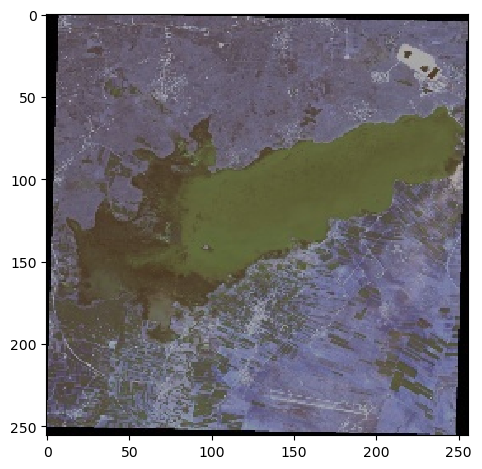

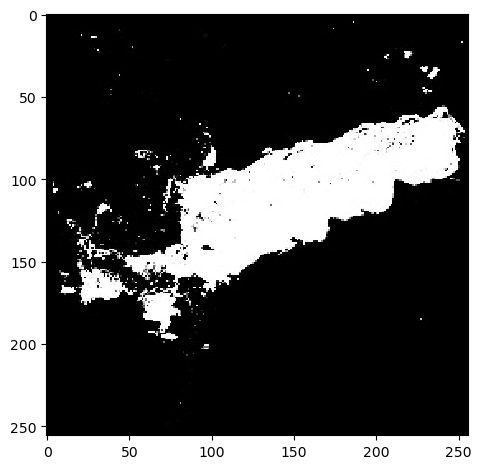

In [7]:
random_num = random.randint(0,516)
imshow(x[random_num])
plt.show()
imshow(y[random_num])
plt.show() 

test_img = x[random_num]
test_img2 = y[random_num]

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [9]:
#UNet model building
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [10]:
def get_model():
    return simple_unet_model(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

In [11]:
model = get_model()
#model.summary()

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history=model.fit(x_train,
          y_train,
          batch_size=20, 
          epochs=30,
          verbose=1,
          validation_data=(x_val, y_val))

Epoch 1/30
184/184 [==============================] - 35s 143ms/step - loss: 0.5015 - accuracy: 0.6012 - val_loss: 0.4579 - val_accuracy: 0.6176
Epoch 2/30
184/184 [==============================] - 24s 129ms/step - loss: 0.4042 - accuracy: 0.6569 - val_loss: 0.4369 - val_accuracy: 0.6489
Epoch 3/30
184/184 [==============================] - 24s 129ms/step - loss: 0.3339 - accuracy: 0.6896 - val_loss: 0.3705 - val_accuracy: 0.6808
Epoch 4/30
184/184 [==============================] - 24s 131ms/step - loss: 0.3103 - accuracy: 0.6991 - val_loss: 0.2998 - val_accuracy: 0.7012
Epoch 5/30
184/184 [==============================] - 24s 131ms/step - loss: 0.2899 - accuracy: 0.7042 - val_loss: 0.3014 - val_accuracy: 0.6992
Epoch 6/30
184/184 [==============================] - 24s 129ms/step - loss: 0.2787 - accuracy: 0.7088 - val_loss: 0.2876 - val_accuracy: 0.7042
Epoch 7/30
184/184 [==============================] - 24s 129ms/step - loss: 0.2675 - accuracy: 0.7118 - val_loss: 0.2691 - val_ac

In [ ]:
model.save("unet_statya_256_auged.h5")